# kitchenware-classification

# EDA

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Upload the files from the image list

In [2]:
path = './kitchenware-classification'
name = 'train.csv'
fullname_train = f'{path}/{name}'

In [3]:
train = pd.read_csv(fullname_train)

In [4]:
train.dtypes

Id        int64
label    object
dtype: object

In [5]:
ext = '.jpg'
train['file'] = train['Id'].astype(str).str.zfill(4)+ ext

In [6]:
train.head()

,Id,label,file
0,560,glass,0560.jpg
1,4675,cup,4675.jpg
2,875,glass,0875.jpg
3,4436,spoon,4436.jpg
4,8265,plate,8265.jpg


In [7]:
path = './kitchenware-classification'
name = 'test.csv'
fullname_test = f'{path}/{name}'
test = pd.read_csv(fullname_test)
test['file'] = test['Id'].astype(str).str.zfill(4) + ext

In [8]:
test.head()

,Id,file
0,678,0678.jpg
1,3962,3962.jpg
2,9271,9271.jpg
3,5133,5133.jpg
4,8842,8842.jpg


In [9]:
name = 'sample_submission.csv'
fullname_sample = f'{path}/{name}'
sample = pd.read_csv(fullname_sample)

In [10]:
sample.head()

,Id,label
0,678,spoon
1,3962,glass
2,9271,spoon
3,5133,plate
4,8842,spoon


### Sample images

In [11]:
sampling = train.sample(6)
sampling.reset_index(drop=True)

,Id,label,file
0,7006,knife,7006.jpg
1,52,cup,0052.jpg
2,4461,knife,4461.jpg
3,5490,knife,5490.jpg
4,7247,glass,7247.jpg
5,710,cup,0710.jpg


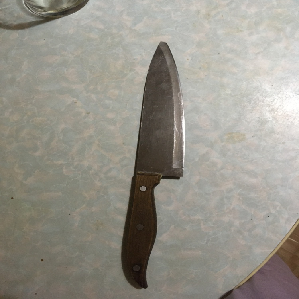

In [12]:
name = sampling.iloc[0].file
fullname_img = f'{path}/images/{name}'
load_img(fullname_img, target_size=(299, 299))

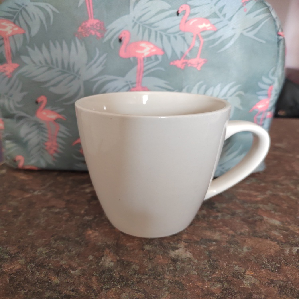

In [13]:
name = sampling.iloc[1].file
fullname_img = f'{path}/images/{name}'
load_img(fullname_img, target_size=(299, 299))

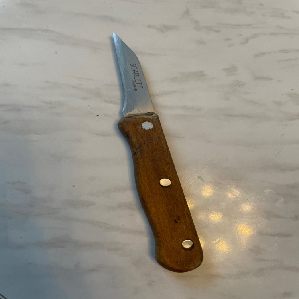

In [14]:
name = sampling.iloc[2].file
fullname_img = f'{path}/images/{name}'
load_img(fullname_img, target_size=(299, 299))

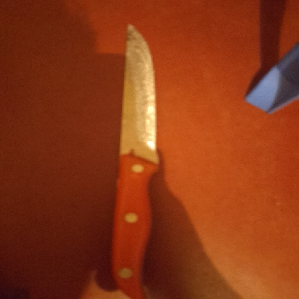

In [15]:
name = sampling.iloc[3].file
fullname_img = f'{path}/images/{name}'
load_img(fullname_img, target_size=(299, 299))

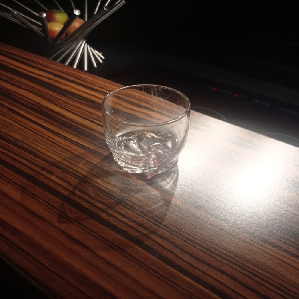

In [16]:
name = sampling.iloc[4].file
fullname_img = f'{path}/images/{name}'
load_img(fullname_img, target_size=(299, 299))

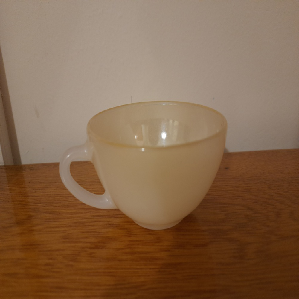

In [17]:
name = sampling.iloc[5].file
fullname_img = f'{path}/images/{name}'
load_img(fullname_img, target_size=(299, 299))

## Download an already trained model.

In [18]:
model = Xception(weights='imagenet', input_shape=(299, 299, 3))

2022-12-07 18:34:33.860917: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Training a new Dense Layer

In [19]:
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)

train_ds = datagen.flow_from_dataframe(
    dataframe = train,
    directory = "kitchenware-classification/images/",
    x_col = 'file',
    y_col = 'label',
    has_ext=True,
    target_size=(150, 150),
    batch_size=32,
    shuffle=True,
    class_mode='categorical',
    subset = "training"
    
)

Found 4170 validated image filenames belonging to 6 classes.


In [20]:
train_ds.class_indices

{'cup': 0, 'fork': 1, 'glass': 2, 'knife': 3, 'plate': 4, 'spoon': 5}

In [21]:
classes = ['cup', 'fork', 'glass', 'knife', 'plate', 'spoon']

In [22]:
val_ds = datagen.flow_from_dataframe(
    dataframe = train,
    directory = "kitchenware-classification/images/",
    x_col = 'file',
    y_col = 'label',
    has_ext = True,
    target_size = (150, 150),
    batch_size = 32,
    shuffle = False,
    class_mode = 'categorical',
    subset = "validation"
    
)

Found 1389 validated image filenames belonging to 6 classes.


In [23]:
test_datagen=ImageDataGenerator(rescale=1./255.)

test_ds=test_datagen.flow_from_dataframe(
    dataframe = test,
    directory = "kitchenware-classification/images/",
    x_col = 'file',
    y_col = None,
    has_ext = True,
    target_size = (150, 150),
    batch_size = 32,
    seed=42,
    shuffle=False,
    class_mode=None,
)

Found 3808 validated image filenames.


In [24]:
base_model = Xception(
    weights='imagenet',
    include_top=False,    #only use conv. layer not include dense layers
    input_shape=(150, 150, 3)
)

base_model.trainable = False    #freeze convolutional layers

### Create a new top

In [25]:
inputs = keras.Input(shape=(150, 150, 3))

base = base_model(inputs, training=False) #applyes base_model to inputs

vectors = keras.layers.GlobalAveragePooling2D()(base) #pooling

outputs = keras.layers.Dense(6)(vectors) #new dense layer

model = keras.Model(inputs, outputs)

### Test with an image

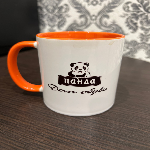

In [55]:
fullname_img = f'{path}/images/0000.jpg'
img = load_img(fullname_img, target_size=(150,150))
img

In [56]:
x = np.array(img)
X = np.array([x])
X1 = preprocess_input(X)
pred = model.predict(X1)
pred.shape

1/1 [==============================] - 0s 66ms/step


(1, 6)

In [57]:
dict(zip(pred[0], classes))

{-0.4511962: 'cup',
 -0.1265912: 'fork',
 -0.14800051: 'glass',
 0.50156486: 'knife',
 -0.27375627: 'plate',
 -1.083567: 'spoon'}

In [58]:
result = dict(zip(pred[0], classes))
result[max(result)]

'knife'

### Train the model

In [59]:
learning_rate = 0.01 
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

loss = keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [60]:
history = model.fit(
    train_ds, 
    epochs=10,    #go over the data 10 times
    validation_data=val_ds
)

Epoch 1/10
131/131 [==============================] - 196s 1s/step - loss: 0.6670 - accuracy: 0.8285 - val_loss: 0.6153 - val_accuracy: 0.8567
Epoch 2/10
131/131 [==============================] - 216s 2s/step - loss: 0.3717 - accuracy: 0.8986 - val_loss: 0.6407 - val_accuracy: 0.8683
Epoch 3/10
131/131 [==============================] - 248s 2s/step - loss: 0.2222 - accuracy: 0.9309 - val_loss: 0.7814 - val_accuracy: 0.8524
Epoch 4/10
131/131 [==============================] - 257s 2s/step - loss: 0.2050 - accuracy: 0.9403 - val_loss: 0.7076 - val_accuracy: 0.8603
Epoch 5/10
131/131 [==============================] - 282s 2s/step - loss: 0.1604 - accuracy: 0.9530 - val_loss: 0.7445 - val_accuracy: 0.8632
Epoch 6/10
131/131 [==============================] - 276s 2s/step - loss: 0.1123 - accuracy: 0.9631 - val_loss: 0.7329 - val_accuracy: 0.8697
Epoch 7/10
131/131 [==============================] - 267s 2s/step - loss: 0.1564 - accuracy: 0.9576 - val_loss: 1.0616 - val_accuracy: 0.8553

In [61]:
import matplotlib.pyplot as plt

%matplotlib inline

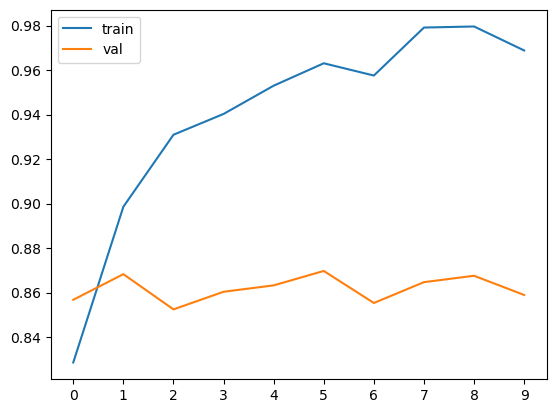

In [62]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()

In [63]:
model.save('model_v1.h5', save_format='h5')

In [ ]:
#### God model more than 80% of accurancy.
#### Adjust the parameters and improve it.

### Adjust the learning_rate: V1

In [64]:
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)

train_ds = datagen.flow_from_dataframe(
    dataframe = train,
    directory = "kitchenware-classification/images/",
    x_col = 'file',
    y_col = 'label',
    has_ext=True,
    target_size=(150, 150),
    batch_size=32,
    shuffle=True,
    class_mode='categorical',
    subset = "training"
    
)
val_ds = datagen.flow_from_dataframe(
    dataframe = train,
    directory = "kitchenware-classification/images/",
    x_col = 'file',
    y_col = 'label',
    has_ext = True,
    target_size = (150, 150),
    batch_size = 32,
    shuffle = False,
    class_mode = 'categorical',
    subset = "validation"
    
)

Found 4170 validated image filenames belonging to 6 classes.
Found 1389 validated image filenames belonging to 6 classes.


In [65]:
def make_model(learning_rate=0.01):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(6)(vectors)
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [68]:
chechpoint = keras.callbacks.ModelCheckpoint(
    'xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [69]:
scores = {}

for lr in [0.1, 0.01, 0.001, 0.0001]:
    print(lr)

    model = make_model(learning_rate=lr)
    history = model.fit(train_ds, 
                        epochs=10, 
                        validation_data=val_ds,
                        callbacks=[chechpoint]
                        )
    scores[lr] = history.history

    print()
    print()

0.1
Epoch 1/10
131/131 [==============================] - 222s 2s/step - loss: 5.4055 - accuracy: 0.8144 - val_loss: 5.4808 - val_accuracy: 0.8467
Epoch 2/10
131/131 [==============================] - 356s 3s/step - loss: 3.8566 - accuracy: 0.8815 - val_loss: 5.5842 - val_accuracy: 0.8330
Epoch 3/10
131/131 [==============================] - 378s 3s/step - loss: 2.5654 - accuracy: 0.9139 - val_loss: 5.4599 - val_accuracy: 0.8690
Epoch 4/10
131/131 [==============================] - 350s 3s/step - loss: 2.0156 - accuracy: 0.9218 - val_loss: 7.3916 - val_accuracy: 0.8337
Epoch 5/10
131/131 [==============================] - 273s 2s/step - loss: 2.7395 - accuracy: 0.9156 - val_loss: 6.6713 - val_accuracy: 0.8654
Epoch 6/10
131/131 [==============================] - 283s 2s/step - loss: 1.2633 - accuracy: 0.9470 - val_loss: 7.7049 - val_accuracy: 0.8697
Epoch 7/10
131/131 [==============================] - 276s 2s/step - loss: 1.5770 - accuracy: 0.9451 - val_loss: 7.9335 - val_accuracy: 0.

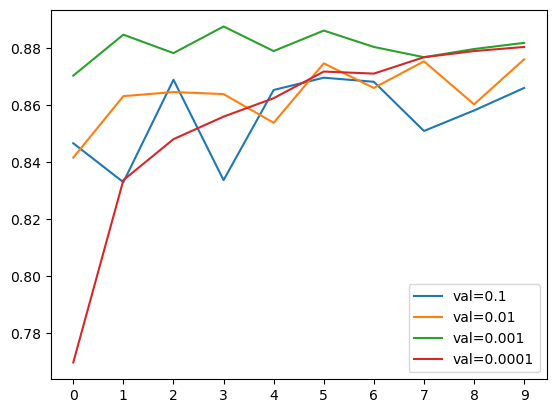

In [70]:
for lr, hist in scores.items():
    #plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))

plt.xticks(np.arange(10))
plt.legend()

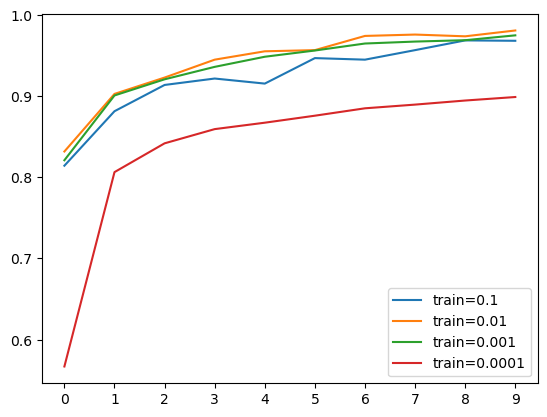

In [71]:
for lr, hist in scores.items():
    plt.plot(hist['accuracy'], label=('train=%s' % lr))
    #plt.plot(hist['val_accuracy'], label=('val=%s' % lr))

plt.xticks(np.arange(10))
plt.legend()

### best learning_rate = 0.01

In [72]:
#Save the model
model.save('model_v2.h5', save_format='h5')

In [73]:
scores_lr = scores

In [76]:
chechpoint = keras.callbacks.ModelCheckpoint(
    'xception_v2_{epoch:02d}_{val_accuracy:.3f}_lr:0.01.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [77]:
learning_rate = 0.01

model = make_model(learning_rate=learning_rate)

history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[chechpoint]
)

Epoch 1/10
131/131 [==============================] - 191s 1s/step - loss: 0.6617 - accuracy: 0.8348 - val_loss: 0.5811 - val_accuracy: 0.8690
Epoch 2/10
131/131 [==============================] - 208s 2s/step - loss: 0.3487 - accuracy: 0.8993 - val_loss: 0.6746 - val_accuracy: 0.8575
Epoch 3/10
131/131 [==============================] - 218s 2s/step - loss: 0.2441 - accuracy: 0.9242 - val_loss: 0.8000 - val_accuracy: 0.8474
Epoch 4/10
131/131 [==============================] - 226s 2s/step - loss: 0.1677 - accuracy: 0.9484 - val_loss: 0.9445 - val_accuracy: 0.8467
Epoch 5/10
131/131 [==============================] - 225s 2s/step - loss: 0.1200 - accuracy: 0.9619 - val_loss: 0.9732 - val_accuracy: 0.8488
Epoch 6/10
131/131 [==============================] - 227s 2s/step - loss: 0.1621 - accuracy: 0.9501 - val_loss: 0.7906 - val_accuracy: 0.8654
Epoch 7/10
131/131 [==============================] - 230s 2s/step - loss: 0.1037 - accuracy: 0.9674 - val_loss: 0.9157 - val_accuracy: 0.8603

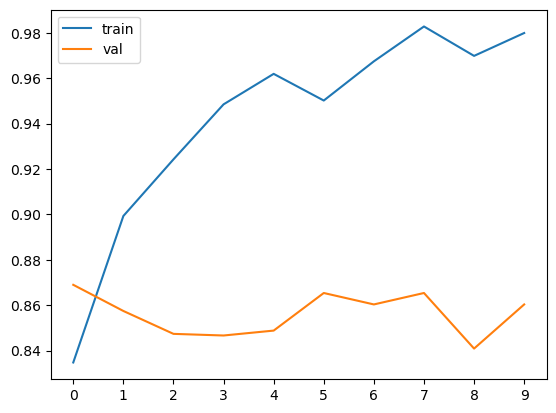

In [78]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()

### Experimenting with different sizes of inner layer: V3

In [79]:
def make_model(learning_rate=0.01, size_inner=100):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    
    outputs = keras.layers.Dense(6)(inner)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [80]:
learning_rate = 0.01

scores = {}

for size in [10, 100, 1000]:
    print(size)

    model = make_model(learning_rate=learning_rate, size_inner=size)
    history = model.fit(train_ds, 
                        epochs=10, 
                        validation_data=val_ds)
    scores[size] = history.history

    print()
    print()


10
Epoch 1/10
131/131 [==============================] - 187s 1s/step - loss: 0.6385 - accuracy: 0.7830 - val_loss: 0.4036 - val_accuracy: 0.8625
Epoch 2/10
131/131 [==============================] - 206s 2s/step - loss: 0.3057 - accuracy: 0.8899 - val_loss: 0.4529 - val_accuracy: 0.8625
Epoch 3/10
131/131 [==============================] - 217s 2s/step - loss: 0.2323 - accuracy: 0.9137 - val_loss: 0.3944 - val_accuracy: 0.8654
Epoch 4/10
131/131 [==============================] - 226s 2s/step - loss: 0.1880 - accuracy: 0.9290 - val_loss: 0.4851 - val_accuracy: 0.8697
Epoch 5/10
131/131 [==============================] - 228s 2s/step - loss: 0.1724 - accuracy: 0.9400 - val_loss: 0.4746 - val_accuracy: 0.8661
Epoch 6/10
131/131 [==============================] - 229s 2s/step - loss: 0.1795 - accuracy: 0.9365 - val_loss: 0.5112 - val_accuracy: 0.8683
Epoch 7/10
131/131 [==============================] - 244s 2s/step - loss: 0.1352 - accuracy: 0.9496 - val_loss: 0.5112 - val_accuracy: 0.8

In [81]:
scores_size_inner = scores

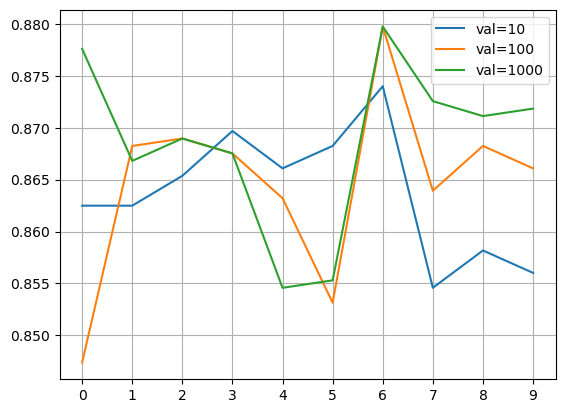

In [83]:
for size, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % size))

plt.xticks(np.arange(10))
#plt.yticks([0.87, 0.88])
plt.grid(True)
plt.legend()

### Best inner size=100

In [84]:
chechpoint = keras.callbacks.ModelCheckpoint(
    'xception_v3_{epoch:02d}_{val_accuracy:.3f}_droprate.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

### Regularization and dropout

In [85]:
def make_model(learning_rate=0.01, size_inner=100, droprate=0.5):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    
    outputs = keras.layers.Dense(6)(drop)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [86]:
learning_rate = 0.01
size = 100

scores = {}

for droprate in [0.0, 0.2, 0.5, 0.8]:
    print(droprate)

    model = make_model(
        learning_rate=learning_rate,
        size_inner=size,
        droprate=droprate
    )

    history = model.fit(train_ds, epochs=30, 
                        validation_data=val_ds,
                        callbacks=[chechpoint])
    
    scores[droprate] = history.history

    print()
    print()

0.0
Epoch 1/30
131/131 [==============================] - 190s 1s/step - loss: 0.5851 - accuracy: 0.8261 - val_loss: 0.3739 - val_accuracy: 0.8618
Epoch 2/30
131/131 [==============================] - 212s 2s/step - loss: 0.2703 - accuracy: 0.9043 - val_loss: 0.4111 - val_accuracy: 0.8711
Epoch 3/30
131/131 [==============================] - 222s 2s/step - loss: 0.2200 - accuracy: 0.9235 - val_loss: 0.4851 - val_accuracy: 0.8546
Epoch 4/30
131/131 [==============================] - 235s 2s/step - loss: 0.1832 - accuracy: 0.9317 - val_loss: 0.4548 - val_accuracy: 0.8560
Epoch 5/30
131/131 [==============================] - 270s 2s/step - loss: 0.1378 - accuracy: 0.9475 - val_loss: 0.4840 - val_accuracy: 0.8668
Epoch 6/30
131/131 [==============================] - 279s 2s/step - loss: 0.1061 - accuracy: 0.9612 - val_loss: 0.5251 - val_accuracy: 0.8596
Epoch 7/30
131/131 [==============================] - 285s 2s/step - loss: 0.1041 - accuracy: 0.9612 - val_loss: 0.6514 - val_accuracy: 0.

Epoch 28/30
131/131 [==============================] - 2845s 22s/step - loss: 0.1544 - accuracy: 0.9472 - val_loss: 0.8294 - val_accuracy: 0.8582
Epoch 29/30
131/131 [==============================] - 200s 2s/step - loss: 0.1434 - accuracy: 0.9532 - val_loss: 0.8470 - val_accuracy: 0.8733
Epoch 30/30
131/131 [==============================] - 210s 2s/step - loss: 0.1340 - accuracy: 0.9556 - val_loss: 0.9210 - val_accuracy: 0.8625


0.5
Epoch 1/30
131/131 [==============================] - 214s 2s/step - loss: 0.7529 - accuracy: 0.7592 - val_loss: 0.3972 - val_accuracy: 0.8560
Epoch 2/30
131/131 [==============================] - 216s 2s/step - loss: 0.5418 - accuracy: 0.8139 - val_loss: 0.4552 - val_accuracy: 0.8351
Epoch 3/30
131/131 [==============================] - 222s 2s/step - loss: 0.5068 - accuracy: 0.8168 - val_loss: 0.4106 - val_accuracy: 0.8510
Epoch 4/30
131/131 [==============================] - 224s 2s/step - loss: 0.4668 - accuracy: 0.8285 - val_loss: 0.3751 - val_accur

Epoch 25/30
131/131 [==============================] - 313s 2s/step - loss: 1.1753 - accuracy: 0.5305 - val_loss: 0.7140 - val_accuracy: 0.8092
Epoch 26/30
131/131 [==============================] - 316s 2s/step - loss: 1.1066 - accuracy: 0.5295 - val_loss: 0.6003 - val_accuracy: 0.7667
Epoch 27/30
131/131 [==============================] - 322s 2s/step - loss: 1.1110 - accuracy: 0.5412 - val_loss: 0.6184 - val_accuracy: 0.8107
Epoch 28/30
131/131 [==============================] - 326s 2s/step - loss: 1.1634 - accuracy: 0.5341 - val_loss: 0.5820 - val_accuracy: 0.8279
Epoch 29/30
131/131 [==============================] - 332s 3s/step - loss: 1.0640 - accuracy: 0.5415 - val_loss: 0.5534 - val_accuracy: 0.8222
Epoch 30/30
131/131 [==============================] - 340s 3s/step - loss: 1.1131 - accuracy: 0.5518 - val_loss: 0.5994 - val_accuracy: 0.8063




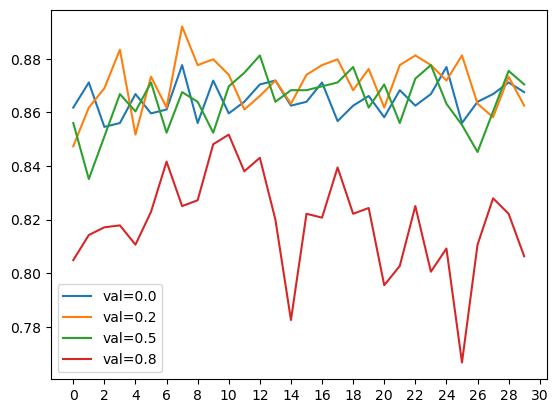

In [87]:
scores_droprate = scores
for droprate, hist in scores_droprate.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % droprate))
    
plt.xticks(np.arange(0,32,2))

#plt.ylim(0.87, 0.895)
plt.legend()

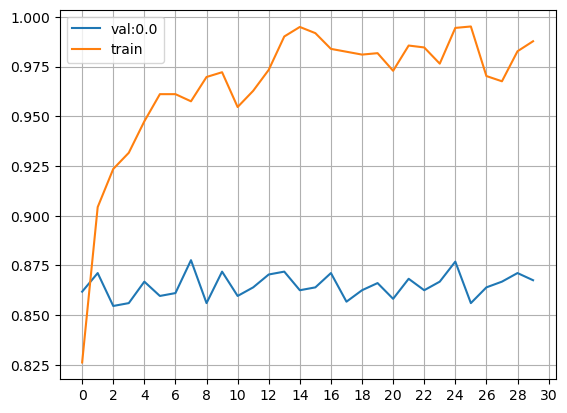

In [90]:
hist1 = scores_droprate[0.0]
plt.plot(hist1['val_accuracy'], label='val:0.0')
plt.plot(hist1['accuracy'], label='train')

plt.xticks(np.arange(0,32,2))
#plt.yticks([0.88, 0.885, 0.8905, 0.895])
plt.legend()
plt.grid(True)

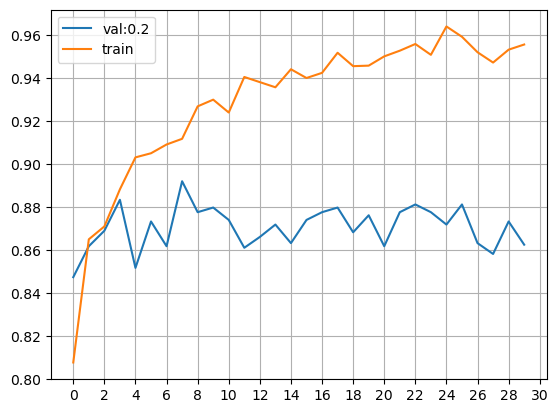

In [89]:
hist1 = scores_droprate[0.2]
plt.plot(hist1['val_accuracy'], label='val:0.2')
plt.plot(hist1['accuracy'], label='train')

plt.xticks(np.arange(0,32,2))
#plt.yticks([0.88, 0.885, 0.8905, 0.895])
plt.legend()
plt.grid(True)

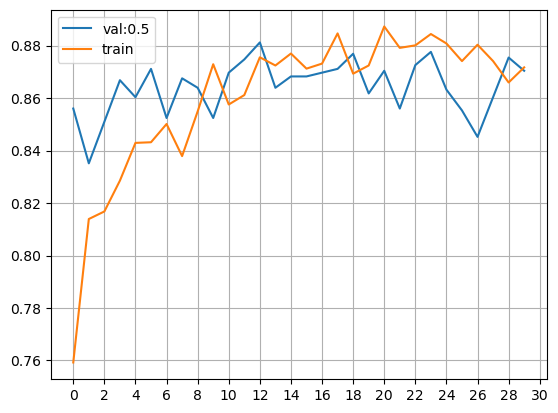

In [88]:
hist1 = scores_droprate[0.5]
plt.plot(hist1['val_accuracy'], label='val:0.5')
plt.plot(hist1['accuracy'], label='train')

plt.xticks(np.arange(0,32,2))
#plt.yticks([0.88, 0.885, 0.8905, 0.895])
plt.legend()
plt.grid(True)

### Best droprate=0.5

In [91]:
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)

train_ds = datagen.flow_from_dataframe(
    dataframe = train,
    directory = "kitchenware-classification/images/",
    x_col = 'file',
    y_col = 'label',
    has_ext=True,
    target_size=(150, 150),
    batch_size=32,
    shuffle=True,
    class_mode='categorical',
    subset = "training"
    
)
val_ds = datagen.flow_from_dataframe(
    dataframe = train,
    directory = "kitchenware-classification/images/",
    x_col = 'file',
    y_col = 'label',
    has_ext = True,
    target_size = (150, 150),
    batch_size = 32,
    shuffle = False,
    class_mode = 'categorical',
    subset = "validation"
    
)

Found 4170 validated image filenames belonging to 6 classes.
Found 1389 validated image filenames belonging to 6 classes.


In [92]:
chechpoint = keras.callbacks.ModelCheckpoint(
    'xception_v3_{epoch:02d}_{val_accuracy:.3f}_droprate:0.5.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [93]:
learning_rate = 0.01
size = 100

scores = {}

for droprate in [0.5]:
    print(droprate)

    model = make_model(
        learning_rate=learning_rate,
        size_inner=size,
        droprate=droprate
    )

    history = model.fit(train_ds, epochs=10, 
                        validation_data=val_ds,
                       callbacks=[chechpoint])
    scores[droprate] = history.history

    print()
    print()

0.5
Epoch 1/10
131/131 [==============================] - 190s 1s/step - loss: 0.7714 - accuracy: 0.7597 - val_loss: 0.4035 - val_accuracy: 0.8539
Epoch 2/10
131/131 [==============================] - 210s 2s/step - loss: 0.5627 - accuracy: 0.7966 - val_loss: 0.4090 - val_accuracy: 0.8661
Epoch 3/10
131/131 [==============================] - 219s 2s/step - loss: 0.4957 - accuracy: 0.8134 - val_loss: 0.4241 - val_accuracy: 0.8445
Epoch 4/10
131/131 [==============================] - 228s 2s/step - loss: 0.4866 - accuracy: 0.8225 - val_loss: 0.3943 - val_accuracy: 0.8675
Epoch 5/10
131/131 [==============================] - 231s 2s/step - loss: 0.4873 - accuracy: 0.8240 - val_loss: 0.4027 - val_accuracy: 0.8582
Epoch 6/10
131/131 [==============================] - 245s 2s/step - loss: 0.4753 - accuracy: 0.8302 - val_loss: 0.4546 - val_accuracy: 0.8654
Epoch 7/10
131/131 [==============================] - 252s 2s/step - loss: 0.4268 - accuracy: 0.8504 - val_loss: 0.4376 - val_accuracy: 0.

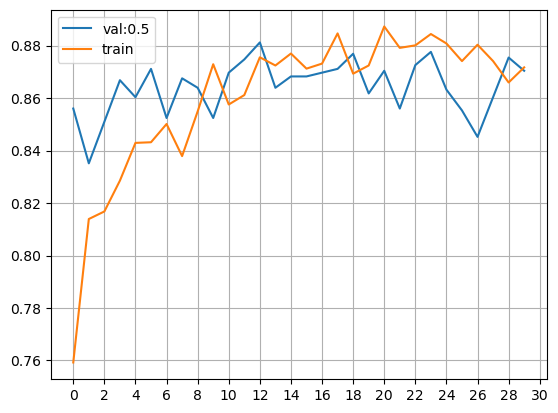

In [94]:
hist2 = scores_droprate[0.5]
plt.plot(hist2['val_accuracy'], label='val:0.5')
plt.plot(hist2['accuracy'], label='train')

plt.xticks(np.arange(0,32,2))
#plt.yticks([0.88, 0.885, 0.8905, 0.895])
plt.legend()
plt.grid(True)

## Data augmentation

In [96]:
chechpoint = keras.callbacks.ModelCheckpoint(
    'xception_v4_{epoch:02d}_{val_accuracy:.3f}_aug.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [97]:
#rotation_range=30,
#width_shift_range=10.0
#height_shift_range=10.0
#shear_range=10,
#zoom_range=0.1
#vertical_flip=True


train_datagen = ImageDataGenerator(rescale=1./255.,
                           validation_split=0.25, 
                           rotation_range=30,
                           width_shift_range=10.0,
                           height_shift_range=10.0,
                           shear_range=10,
                           zoom_range=0.1,
                           vertical_flip=True
                            )

train_ds = train_datagen.flow_from_dataframe(
    dataframe = train,
    directory = "kitchenware-classification/images/",
    x_col = 'file',
    y_col = 'label',
    has_ext=True,
    target_size=(150, 150),
    batch_size=32,
    shuffle=True,
    class_mode='categorical',
    subset = "training"
    
)

val_datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)

val_ds = val_datagen.flow_from_dataframe(
    dataframe = train,
    directory = "kitchenware-classification/images/",
    x_col = 'file',
    y_col = 'label',
    has_ext = True,
    target_size = (150, 150),
    batch_size = 32,
    shuffle = False,
    class_mode = 'categorical',
    subset = "validation"
    
)

Found 4170 validated image filenames belonging to 6 classes.
Found 1389 validated image filenames belonging to 6 classes.


In [98]:
learning_rate = 0.01
size = 100
droprate = 0.5

model = make_model(
        learning_rate=learning_rate,
        size_inner=size,
        droprate=droprate
)

history = model.fit(train_ds, epochs=10, 
                        validation_data=val_ds,
                       callbacks=[chechpoint])

Epoch 1/10
131/131 [==============================] - 234s 2s/step - loss: 1.1086 - accuracy: 0.6367 - val_loss: 0.4645 - val_accuracy: 0.8344
Epoch 2/10
131/131 [==============================] - 275s 2s/step - loss: 0.7878 - accuracy: 0.7110 - val_loss: 0.4670 - val_accuracy: 0.7905
Epoch 3/10
131/131 [==============================] - 292s 2s/step - loss: 0.7817 - accuracy: 0.7086 - val_loss: 0.4413 - val_accuracy: 0.8517
Epoch 4/10
131/131 [==============================] - 295s 2s/step - loss: 0.7208 - accuracy: 0.7305 - val_loss: 0.4828 - val_accuracy: 0.8575
Epoch 5/10
131/131 [==============================] - 268s 2s/step - loss: 0.7238 - accuracy: 0.7271 - val_loss: 0.4141 - val_accuracy: 0.8582
Epoch 6/10
131/131 [==============================] - 271s 2s/step - loss: 0.6862 - accuracy: 0.7520 - val_loss: 0.4181 - val_accuracy: 0.8618
Epoch 7/10
131/131 [==============================] - 244s 2s/step - loss: 0.7010 - accuracy: 0.7367 - val_loss: 0.4058 - val_accuracy: 0.8668

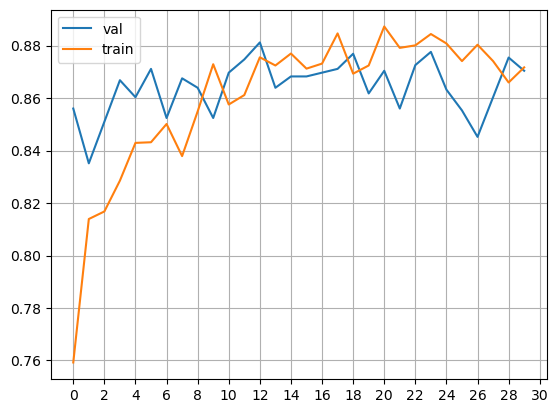

In [101]:
scores_aug = scores
hist5 = scores_aug[0.5]
plt.plot(hist2['val_accuracy'], label='val')
plt.plot(hist2['accuracy'], label='train')

plt.xticks(np.arange(0,32,2))
#plt.yticks([0.88, 0.885, 0.8905, 0.895])
plt.legend()
plt.grid(True)

## Test of different parameters for data augmentation.

In [114]:
chechpoint = keras.callbacks.ModelCheckpoint(
    'xception_v5_{epoch:02d}_{val_accuracy:.3f}_aug.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [115]:
#rotation_range=30,
#width_shift_range=10.0
#height_shift_range=10.0
#shear_range=10,
#zoom_range=0.1
#vertical_flip=True


train_datagen = ImageDataGenerator(rescale=1./255.,
                           validation_split=0.25, 
                           rotation_range=30,
                            )

train_ds = train_datagen.flow_from_dataframe(
    dataframe = train,
    directory = "kitchenware-classification/images/",
    x_col = 'file',
    y_col = 'label',
    has_ext=True,
    target_size=(150, 150),
    batch_size=32,
    shuffle=True,
    class_mode='categorical',
    subset = "training"
    
)

val_datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)

val_ds = val_datagen.flow_from_dataframe(
    dataframe = train,
    directory = "kitchenware-classification/images/",
    x_col = 'file',
    y_col = 'label',
    has_ext = True,
    target_size = (150, 150),
    batch_size = 32,
    shuffle = False,
    class_mode = 'categorical',
    subset = "validation"
    
)

Found 4170 validated image filenames belonging to 6 classes.
Found 1389 validated image filenames belonging to 6 classes.


In [116]:
learning_rate = 0.01
size = 100
droprate = 0.5

model = make_model(
        learning_rate=learning_rate,
        size_inner=size,
        droprate=droprate
)

history = model.fit(train_ds, epochs=10, 
                        validation_data=val_ds,
                       callbacks=[chechpoint])

Epoch 1/10
131/131 [==============================] - 190s 1s/step - loss: 0.9233 - accuracy: 0.7019 - val_loss: 0.4386 - val_accuracy: 0.8438
Epoch 2/10
131/131 [==============================] - 210s 2s/step - loss: 0.6692 - accuracy: 0.7520 - val_loss: 0.4532 - val_accuracy: 0.8524
Epoch 3/10
131/131 [==============================] - 231s 2s/step - loss: 0.6615 - accuracy: 0.7674 - val_loss: 0.3757 - val_accuracy: 0.8697
Epoch 4/10
131/131 [==============================] - 231s 2s/step - loss: 0.5937 - accuracy: 0.7827 - val_loss: 0.3899 - val_accuracy: 0.8690
Epoch 5/10
131/131 [==============================] - 228s 2s/step - loss: 0.6136 - accuracy: 0.7674 - val_loss: 0.4210 - val_accuracy: 0.8611
Epoch 6/10
131/131 [==============================] - 231s 2s/step - loss: 0.6375 - accuracy: 0.7729 - val_loss: 0.4133 - val_accuracy: 0.8683
Epoch 7/10
131/131 [==============================] - 248s 2s/step - loss: 0.5891 - accuracy: 0.7890 - val_loss: 0.4218 - val_accuracy: 0.8704

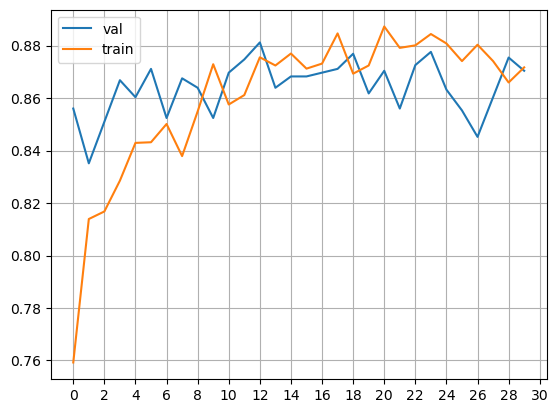

In [118]:
scores_aug2 = scores
hist5 = scores_aug2[0.5]
plt.plot(hist2['val_accuracy'], label='val')
plt.plot(hist2['accuracy'], label='train')

plt.xticks(np.arange(0,32,2))
#plt.yticks([0.88, 0.885, 0.8905, 0.895])
plt.legend()
plt.grid(True)

#### The model does not improve

### Training a larger model

In [119]:
input_size = 299

In [120]:
def make_model(input_size = 150,learning_rate=0.01, size_inner=100, 
               droprate=0.5):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(input_size, input_size, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(input_size, input_size, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    
    outputs = keras.layers.Dense(6)(drop)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [121]:
train_datagen = ImageDataGenerator(rescale=1./255.,
                           validation_split=0.25)

train_ds = train_datagen.flow_from_dataframe(
    dataframe = train,
    directory = "kitchenware-classification/images/",
    x_col = 'file',
    y_col = 'label',
    has_ext=True,
    target_size=(input_size, input_size),
    batch_size=32,
    shuffle=True,
    class_mode='categorical',
    subset = "training"
    
)

val_datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)

val_ds = val_datagen.flow_from_dataframe(
    dataframe = train,
    directory = "kitchenware-classification/images/",
    x_col = 'file',
    y_col = 'label',
    has_ext = True,
    target_size = (input_size, input_size),
    batch_size = 32,
    shuffle = False,
    class_mode = 'categorical',
    subset = "validation"
    
)

Found 4170 validated image filenames belonging to 6 classes.
Found 1389 validated image filenames belonging to 6 classes.


In [122]:
chechpoint = keras.callbacks.ModelCheckpoint(
    'xception_v4_{epoch:02d}_{val_accuracy:.3f}_larger.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [123]:
learning_rate = 0.01
size = 100
droprate = 0.5
input_size = 299

model = make_model(
        input_size = 299,
        learning_rate=learning_rate,
        size_inner=size,
        droprate=droprate
)

history = model.fit(train_ds, epochs=10, 
                        validation_data=val_ds,
                       callbacks=[chechpoint])

Epoch 1/10
131/131 [==============================] - 942s 7s/step - loss: 0.3551 - accuracy: 0.8875 - val_loss: 0.1385 - val_accuracy: 0.9482
Epoch 2/10
131/131 [==============================] - 1000s 8s/step - loss: 0.2786 - accuracy: 0.9082 - val_loss: 0.1619 - val_accuracy: 0.9395
Epoch 3/10
131/131 [==============================] - 1055s 8s/step - loss: 0.2651 - accuracy: 0.9127 - val_loss: 0.1607 - val_accuracy: 0.9482
Epoch 4/10
131/131 [==============================] - 1045s 8s/step - loss: 0.2431 - accuracy: 0.9230 - val_loss: 0.1649 - val_accuracy: 0.9532
Epoch 5/10
131/131 [==============================] - 1090s 8s/step - loss: 0.2171 - accuracy: 0.9309 - val_loss: 0.2805 - val_accuracy: 0.9323
Epoch 6/10
131/131 [==============================] - 1010s 8s/step - loss: 0.2281 - accuracy: 0.9237 - val_loss: 0.1747 - val_accuracy: 0.9546
Epoch 7/10
131/131 [==============================] - 2183s 17s/step - loss: 0.2127 - accuracy: 0.9254 - val_loss: 0.1571 - val_accuracy:

In [124]:
#Save the model
model.save('kitchenware-model.h5', save_format='h5')

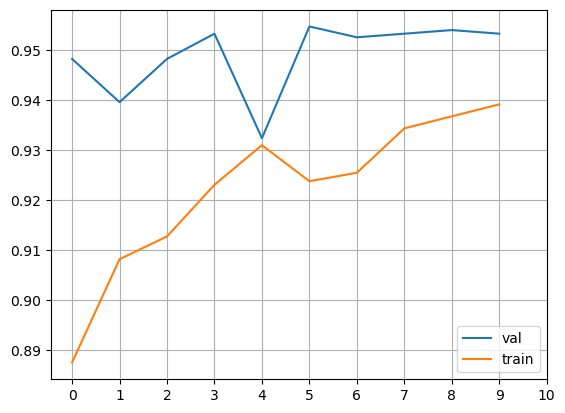

In [136]:
hist3 = history.history
plt.plot(hist3['val_accuracy'], label='val')
plt.plot(hist3['accuracy'], label='train')

plt.xticks(np.arange(0,11,1))

plt.legend()
plt.grid(True)

In [137]:
learning_rate = 0.01
size = 100
droprate = 0.5
input_size = 299

model = make_model(
        input_size = 299,
        learning_rate=learning_rate,
        size_inner=size,
        droprate=droprate
)

history = model.fit(train_ds, epochs=30, 
                        validation_data=val_ds,
                       callbacks=[chechpoint])

Epoch 1/30
131/131 [==============================] - 853s 7s/step - loss: 0.3935 - accuracy: 0.8729 - val_loss: 0.2370 - val_accuracy: 0.9158
Epoch 2/30
131/131 [==============================] - 933s 7s/step - loss: 0.2672 - accuracy: 0.9134 - val_loss: 0.1468 - val_accuracy: 0.9510
Epoch 3/30
131/131 [==============================] - 1040s 8s/step - loss: 0.2407 - accuracy: 0.9228 - val_loss: 0.1581 - val_accuracy: 0.9489
Epoch 4/30
131/131 [==============================] - 1044s 8s/step - loss: 0.1937 - accuracy: 0.9355 - val_loss: 0.1628 - val_accuracy: 0.9510
Epoch 5/30
131/131 [==============================] - 1043s 8s/step - loss: 0.2077 - accuracy: 0.9348 - val_loss: 0.1805 - val_accuracy: 0.9496
Epoch 6/30
131/131 [==============================] - 1029s 8s/step - loss: 0.1965 - accuracy: 0.9365 - val_loss: 0.1538 - val_accuracy: 0.9546
Epoch 7/30
131/131 [==============================] - 1026s 8s/step - loss: 0.2078 - accuracy: 0.9319 - val_loss: 0.1604 - val_accuracy: 0

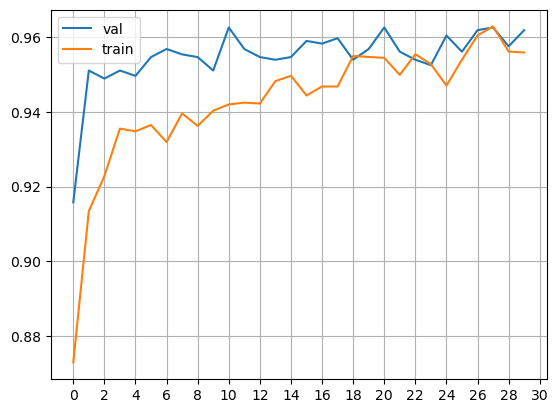

In [139]:
hist4 = history.history
plt.plot(hist4['val_accuracy'], label='val')
plt.plot(hist4['accuracy'], label='train')

plt.xticks(np.arange(0,32,2))

plt.legend()
plt.grid(True)